In [5]:
# 0. Imports básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
plt.rcParams['figure.figsize'] = (8,5)

# 1. Carregar dados
df = pd.read_csv("/crop_yield.csv")
df.head()

,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


In [6]:
# 2. Verificações iniciais
print("Shape:", df.shape)
print(df.dtypes)
print("\nMissing per column:\n", df.isnull().sum())
display(df.describe(include='all'))

Shape: (156, 6)
Crop                                     object
Precipitation (mm day-1)                float64
Specific Humidity at 2 Meters (g/kg)    float64
Relative Humidity at 2 Meters (%)       float64
Temperature at 2 Meters (C)             float64
Yield                                     int64
dtype: object

Missing per column:
 Crop                                    0
Precipitation (mm day-1)                0
Specific Humidity at 2 Meters (g/kg)    0
Relative Humidity at 2 Meters (%)       0
Temperature at 2 Meters (C)             0
Yield                                   0
dtype: int64


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
count,156,156.000000,156.000000,156.000000,156.00000,156.000000
unique,4,NaN,NaN,NaN,NaN,NaN
top,"Cocoa, beans",NaN,NaN,NaN,NaN,NaN
freq,39,NaN,NaN,NaN,NaN,NaN
mean,NaN,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,NaN,289.457914,0.293923,0.996226,0.26105,70421.958897
min,NaN,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,NaN,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,NaN,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,NaN,2718.080000,18.400000,85.510000,26.30000,67518.750000


In [9]:
# 3. Garantir nomes (ajuste conforme seu csv)
numeric_cols = ['Precipitation (mm day-1)',
                'Specific Humidity at 2 Meters (g/kg)',
                'Relative Humidity at 2 Meters (%)',
                'Temperature at 2 Meters (C)',
                'Yield']
cat_col = 'Crop'
# Converter numeric coerentemente:
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

In [10]:
# 4. Estatísticas por cultura
group = df.groupby(cat_col)['Yield'].agg(['count','mean','median','std','min','max']).reset_index()
display(group.sort_values('mean', ascending=False))

,Crop,count,mean,median,std,min,max
1,Oil palm fruit,39,175804.692308,175629.0,14919.869752,142425,203399
2,"Rice, paddy",39,32099.666667,31101.0,4789.948436,24686,42550
0,"Cocoa, beans",39,8883.128205,8848.0,1745.030586,5765,13056
3,"Rubber, natural",39,7824.897436,7817.0,1600.255042,5249,10285


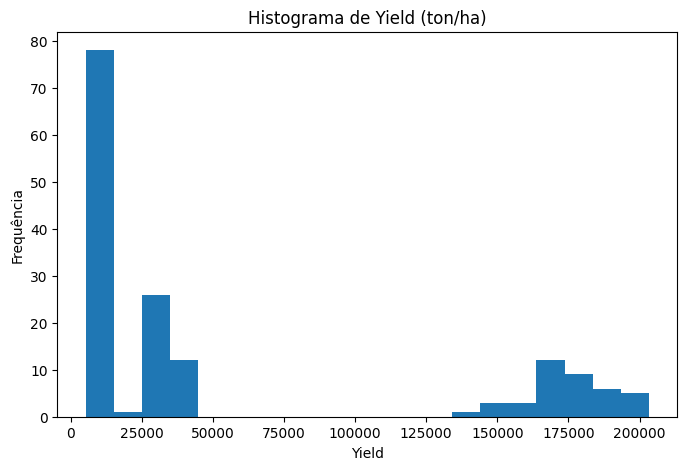

<Figure size 800x500 with 0 Axes>

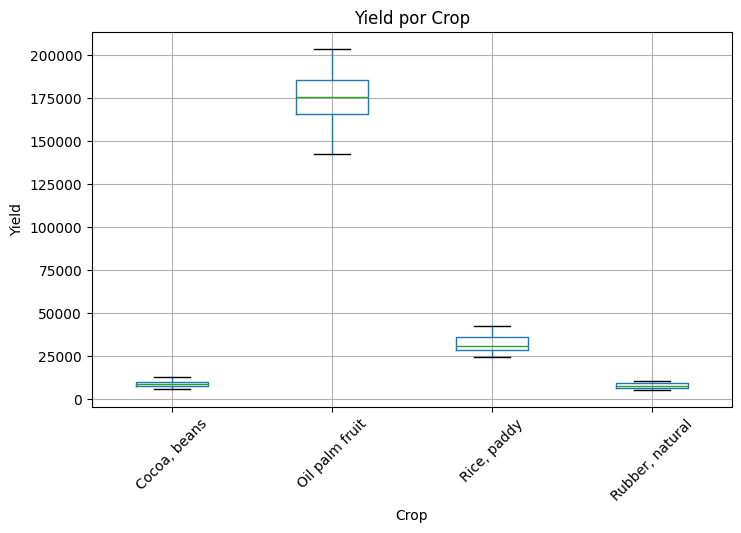

In [11]:
# 5. Histogramas e boxplot do rendimento
plt.figure()
plt.hist(df['Yield'].dropna(), bins=20)
plt.title('Histograma de Yield (ton/ha)')
plt.xlabel('Yield')
plt.ylabel('Frequência')
plt.show()

plt.figure()
df.boxplot(column='Yield', by=cat_col, rot=45)
plt.title('Yield por Crop')
plt.suptitle('')
plt.ylabel('Yield')
plt.show()

,Yield
Yield,1.000000
Precipitation (mm day-1),0.018830
Temperature at 2 Meters (C),0.013007
Specific Humidity at 2 Meters (g/kg),0.012651
Relative Humidity at 2 Meters (%),0.000008


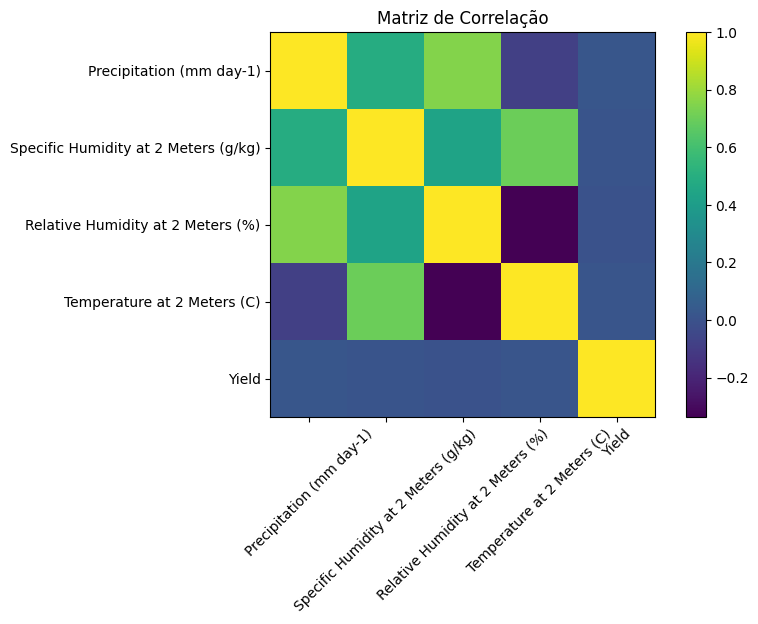

In [12]:
# 6. Correlação com Yield (matriz)
corr = df[numeric_cols].corr()
display(corr['Yield'].sort_values(ascending=False))
# Heatmap básico (matplotlib)
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Matriz de Correlação")
plt.show()

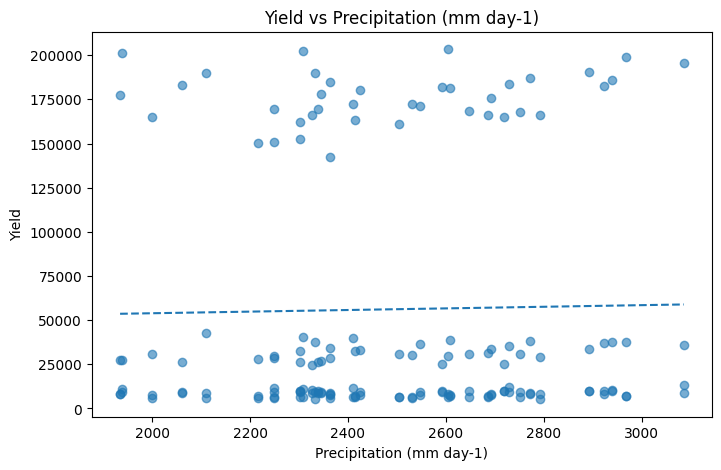

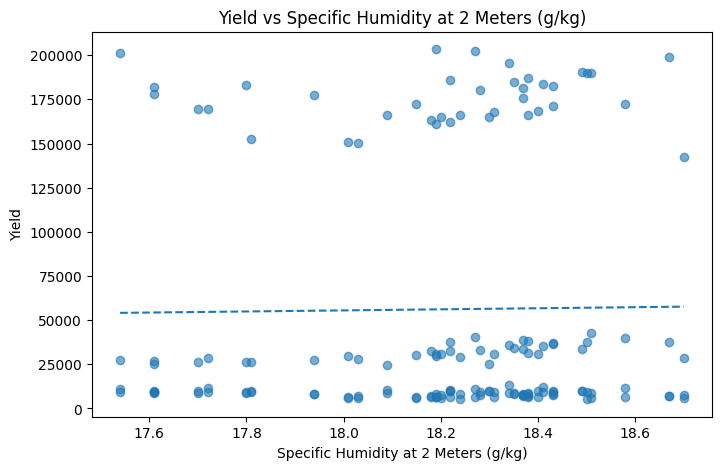

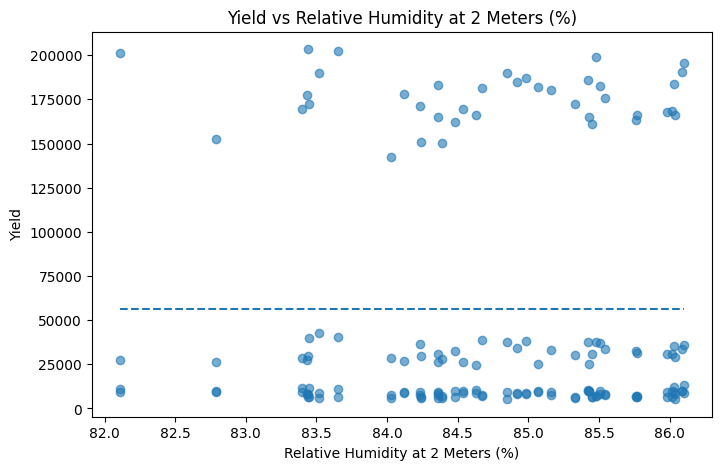

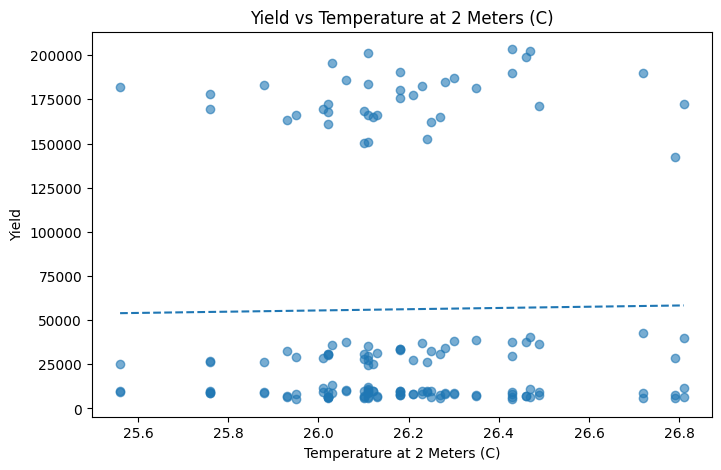

In [13]:
# 7. Scatter Yield vs features com linha de tendência
for feat in [c for c in numeric_cols if c!='Yield']:
    plt.figure()
    plt.scatter(df[feat], df['Yield'], alpha=0.6)
    # regressão linear simples pra visual
    mask = df[feat].notnull() & df['Yield'].notnull()
    if mask.sum() > 1:
        m,b = np.polyfit(df.loc[mask, feat], df.loc[mask, 'Yield'], 1)
        xs = np.linspace(df[feat].min(), df[feat].max(), 100)
        plt.plot(xs, m*xs + b, linestyle='--')
    plt.xlabel(feat)
    plt.ylabel('Yield')
    plt.title(f'Yield vs {feat}')
    plt.show()

In [14]:
# 8. Preparar dados para cluster (somente variáveis ambientais)
X = df[['Precipitation (mm day-1)',
        'Specific Humidity at 2 Meters (g/kg)',
        'Relative Humidity at 2 Meters (%)',
        'Temperature at 2 Meters (C)']].dropna()
X_index = X.index  # guardar índices originais
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

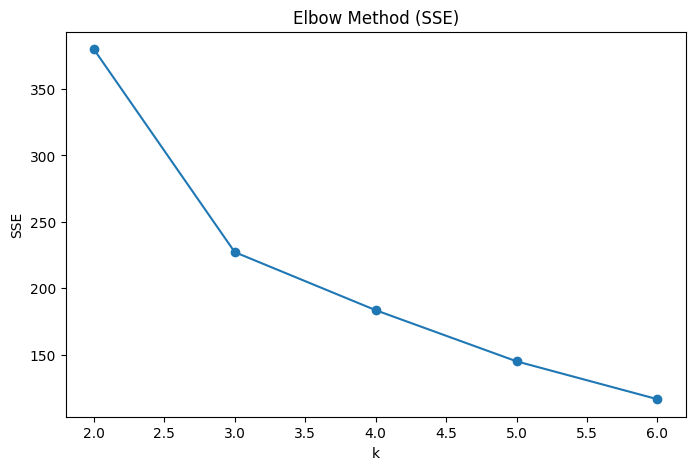

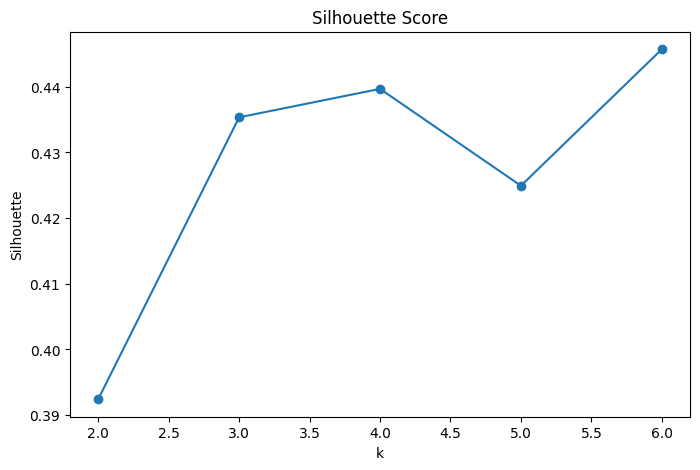

In [15]:
# 9. Elbow + Silhouette para KMeans
sse = []
sil = []
K = range(2,7)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    sse.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, km.labels_))
plt.figure()
plt.plot(K, sse, '-o')
plt.xlabel('k'); plt.ylabel('SSE'); plt.title('Elbow Method (SSE)')
plt.show()

plt.figure()
plt.plot(K, sil, '-o')
plt.xlabel('k'); plt.ylabel('Silhouette'); plt.title('Silhouette Score')
plt.show()

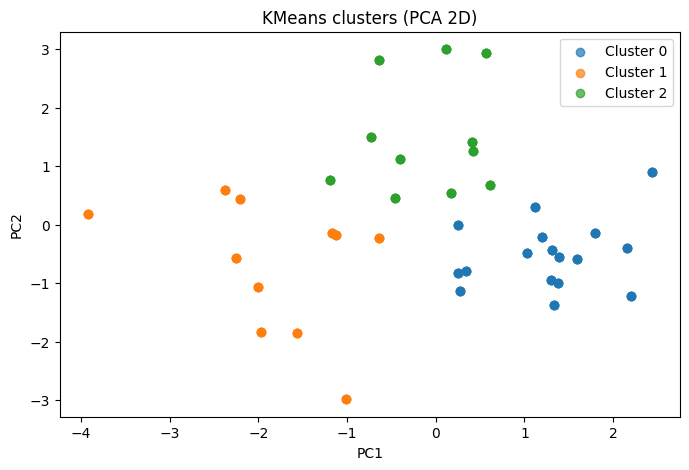

In [16]:
# 10. KMeans com k escolhido (ajuste k conforme plots)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
labels = kmeans.labels_

# Anexar labels ao df original (apenas nas linhas usadas)
df.loc[X_index, 'cluster_kmeans'] = labels

# PCA 2D para visualizar clusters
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X_scaled)
plt.figure()
for cl in range(k):
    mask = labels == cl
    plt.scatter(proj[mask,0], proj[mask,1], label=f'Cluster {cl}', alpha=0.7)
plt.legend()
plt.title('KMeans clusters (PCA 2D)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

In [17]:
# 11. Resumo de rendimento por cluster
cluster_summary = df.groupby('cluster_kmeans')['Yield'].agg(['count','mean','median','std','min','max']).reset_index()
display(cluster_summary.sort_values('mean', ascending=False))

,cluster_kmeans,count,mean,median,std,min,max
2,2.0,44,57453.000000,20158.0,72263.521555,5571,203399
0,0.0,68,56736.544118,19153.5,71004.809259,5249,199074
1,1.0,44,53951.500000,18123.0,69220.556028,5765,201436


In [18]:
# 12. DBSCAN para outliers
db = DBSCAN(eps=0.5, min_samples=5)
db_labels = db.fit_predict(X_scaled)
df.loc[X_index, 'dbscan_label'] = db_labels
n_outliers = (db_labels == -1).sum()
print("Outliers DBSCAN (label -1):", n_outliers)
display(df[df['dbscan_label']==-1].head(20))  # veja as primeiras suspeitas

Outliers DBSCAN (label -1): 108


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield,cluster_kmeans,dbscan_label
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560,1.0,-1.0
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253,1.0,-1.0
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456,1.0,-1.0
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321,1.0,-1.0
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800,1.0,-1.0
5,"Cocoa, beans",2339.30,17.70,84.54,25.76,8850,1.0,-1.0
8,"Cocoa, beans",2061.61,17.80,84.36,25.88,9201,1.0,-1.0
9,"Cocoa, beans",1934.62,17.94,83.43,26.21,8300,1.0,-1.0
15,"Cocoa, beans",2414.79,18.18,85.76,25.93,7138,0.0,-1.0
16,"Cocoa, beans",1999.53,18.20,84.36,26.27,7525,2.0,-1.0


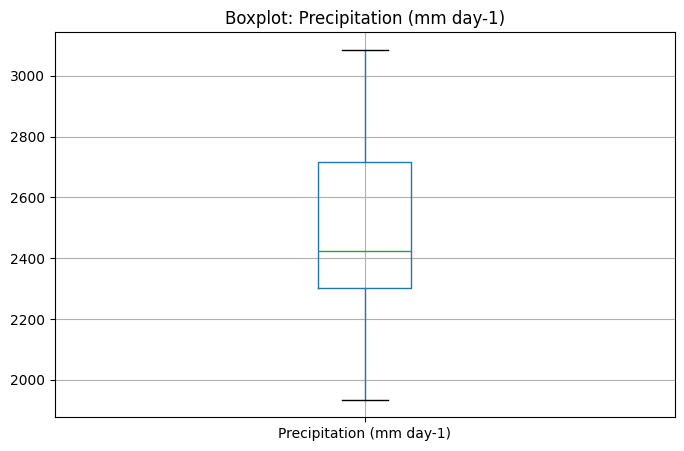

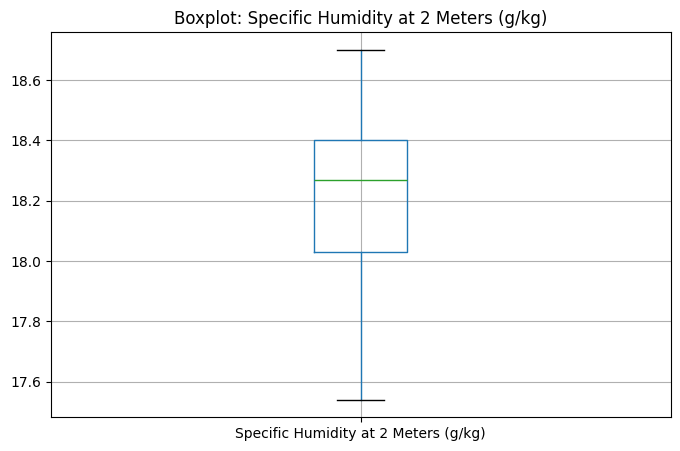

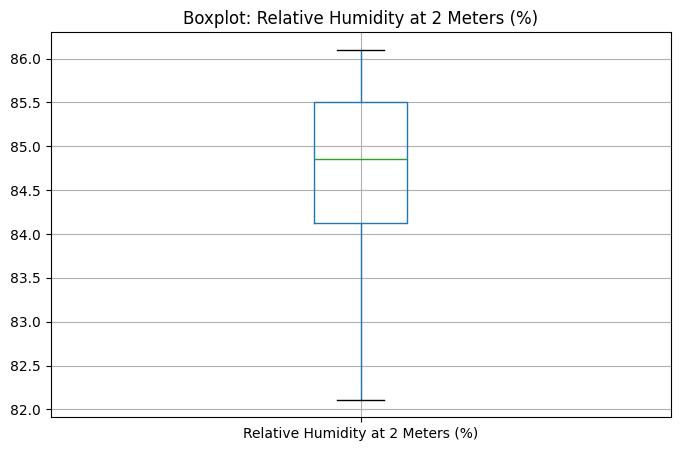

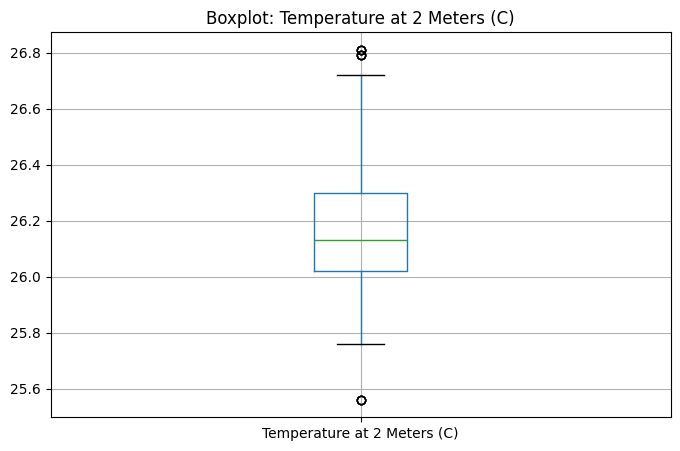

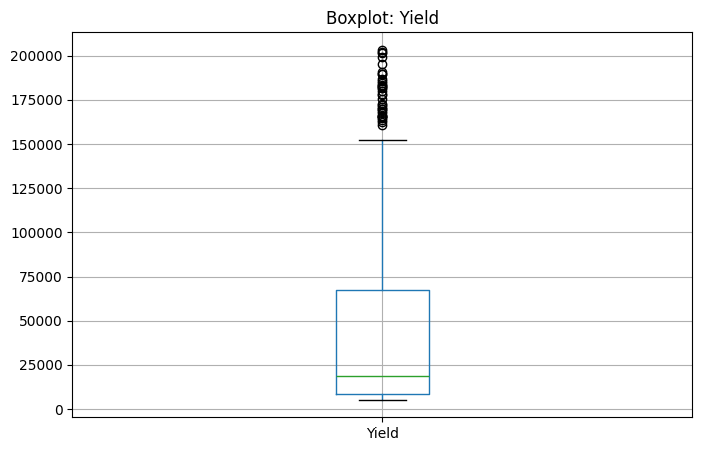

In [19]:
# 13. Boxplots por variável para achar pontos extremos
for col in ['Precipitation (mm day-1)','Specific Humidity at 2 Meters (g/kg)',
            'Relative Humidity at 2 Meters (%)','Temperature at 2 Meters (C)','Yield']:
    plt.figure()
    df.boxplot(column=col)
    plt.title(f'Boxplot: {col}')
    plt.show()

In [20]:
# 14. Criar tabela final de "casos suspeitos" (outliers e/ou clusters extremos)
suspects = df[(df['dbscan_label']==-1) | (df['Yield'] > df['Yield'].quantile(0.99)) | (df['Yield'] < df['Yield'].quantile(0.01))]
display(suspects.sort_values('Yield'))
# Salvar CSV com os suspeitos
suspects.to_csv("suspected_outliers_and_extremes.csv", index=False)

,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield,cluster_kmeans,dbscan_label
135,"Rubber, natural",2792.95,18.24,86.04,25.95,5249,0.0,1.0
154,"Rubber, natural",2333.46,18.50,84.85,26.43,5571,2.0,-1.0
134,"Rubber, natural",2362.80,18.70,84.03,26.79,5693,2.0,-1.0
155,"Rubber, natural",2109.34,18.51,83.52,26.72,5903,2.0,-1.0
133,"Rubber, natural",1999.53,18.20,84.36,26.27,6008,2.0,-1.0
...,...,...,...,...,...,...,...,...
66,Oil palm fruit,3085.79,18.34,86.10,26.03,195523,0.0,-1.0
75,Oil palm fruit,2967.41,18.67,85.48,26.46,199074,0.0,-1.0
40,Oil palm fruit,1938.42,17.54,82.11,26.11,201436,1.0,-1.0
73,Oil palm fruit,2308.51,18.27,83.65,26.47,202379,2.0,-1.0


# 🌾 FarmTech Solutions – Análise Exploratória e Tendências de Safra

## Contexto
Este projeto faz parte da **Fase 5 do PBL FIAP**. O cenário envolve a **FarmTech Solutions**, que presta serviços de Inteligência Artificial para uma fazenda de médio porte (200 hectares).  
O objetivo é analisar os dados de clima e solo, explorar tendências de rendimento das culturas e identificar cenários discrepantes (outliers).

## Escopo
Responsável por:
- **Análise exploratória dos dados (EDA)**  
- **Identificação de tendências de rendimento via clusterização (KMeans + PCA)**  
- **Detecção de cenários discrepantes (outliers com DBSCAN e boxplots)**  
- **Documentação e vídeo explicativo dessa análise**  

*(Os modelos preditivos supervisionados fazem parte de outra etapa do grupo e não estão neste notebook.)*

## Dataset
Arquivo: `crop_yield.csv`  
Variáveis principais:
- Cultura  
- Precipitação (mm/dia)  
- Umidade específica a 2m (g/kg)  
- Umidade relativa a 2m (%)  
- Temperatura a 2m (ºC)  
- Rendimento (ton/ha)  

## Principais Etapas
1. **Exploração inicial** – estatísticas descritivas, distribuições e correlações.  
2. **Clusterização (KMeans + PCA)** – identificação de tendências de rendimento e agrupamentos distintos de culturas.  
3. **Detecção de outliers (DBSCAN + análises estatísticas)** – identificação de pontos discrepantes de produtividade.  
4. **Exportação de casos suspeitos** – arquivo adicional com registros extremos.  

## Estrutura do Repositório
- `vicenzo_montefusco_rmXXXXX_pbl_fase4.ipynb` → Notebook completo com a análise.  
- `crop_yield.csv` → Base de dados fornecida.  
- `suspected_outliers_and_extremes.csv` → Registros suspeitos/exportados como potenciais **outliers**.  

### Sobre o arquivo de outliers
O arquivo `suspected_outliers_and_extremes.csv` contém as linhas do dataset que apresentaram **valores discrepantes** segundo:
- Análise estatística (boxplots, z-score)  
- Clusterização DBSCAN  

Esse material serve como **evidência** dos cenários incomuns de rendimento e pode apoiar decisões futuras da fazenda, como investigar condições climáticas anômalas ou problemas pontuais no solo.

## Demonstração em Vídeo
➡️ [Link para o vídeo no YouTube](COLOQUE_AQUI_SEU_LINK) *(modo não listado)*

## Conclusões
- Foram identificadas **tendências claras** nos rendimentos com base em clima e solo.  
- Clusters distintos de produtividade foram encontrados, revelando perfis diferentes de culturas.  
- Alguns **outliers** foram detectados, que podem indicar erros de coleta ou situações reais de stress agrícola.  
- Limitações: dataset relativamente pequeno, análise restrita a variáveis fornecidas.  
---
